# TAT-C: Collect Orbit and Ground Track Example

This example demonstrates how to use direct function calls of the low-level TAT-C library to collect satellite orbit and ground tracks.

Similar to the _Collect Observations_ example, the first steps are to define the satellites for the mission. This example again uses the NOAA-20 satellite with a two-line elements model from July 2022 and a VIIRS instrument with field of regard computed based on a 834km altitude and 3000km swath width. This example also adds an operational requirement that targets must be sunlit for valid observations.

In [9]:
from tatc import utils
from tatc.schemas import Instrument, Satellite, TwoLineElements

viirs = Instrument(
    name="VIIRS",
    field_of_regard=utils.swath_width_to_field_of_regard(834000, 3000000),
    req_target_sunlit=True,
)
noaa20 = Satellite(
    name="NOAA 20",
    orbit=TwoLineElements(
        tle=[
            "1 43013U 17073A   22195.78278435  .00000038  00000+0  38919-4 0  9996",
            "2 43013  98.7169 133.9110 0001202  63.8768 296.2532 14.19561306241107",
        ]
    ),
    instruments=[viirs],
)

Next, we can identify the starting and ending times and sampling interval of a sample mission period. The starting time is noon UTC on July 14, 2022 and the ending time is 2 hours later (noon UTC on July 16, 2022). The sampling frequency is set to 2 minutes.

In [2]:
from datetime import datetime, timedelta, timezone
import pandas as pd

start = datetime(year=2022, month=7, day=14, hour=12, tzinfo=timezone.utc)
end = start + timedelta(hours=2)
delta = timedelta(minutes=2)
times = pd.date_range(start, end, freq=delta)
display(times)

DatetimeIndex(['2022-07-14 12:00:00+00:00', '2022-07-14 12:02:00+00:00',
               '2022-07-14 12:04:00+00:00', '2022-07-14 12:06:00+00:00',
               '2022-07-14 12:08:00+00:00', '2022-07-14 12:10:00+00:00',
               '2022-07-14 12:12:00+00:00', '2022-07-14 12:14:00+00:00',
               '2022-07-14 12:16:00+00:00', '2022-07-14 12:18:00+00:00',
               '2022-07-14 12:20:00+00:00', '2022-07-14 12:22:00+00:00',
               '2022-07-14 12:24:00+00:00', '2022-07-14 12:26:00+00:00',
               '2022-07-14 12:28:00+00:00', '2022-07-14 12:30:00+00:00',
               '2022-07-14 12:32:00+00:00', '2022-07-14 12:34:00+00:00',
               '2022-07-14 12:36:00+00:00', '2022-07-14 12:38:00+00:00',
               '2022-07-14 12:40:00+00:00', '2022-07-14 12:42:00+00:00',
               '2022-07-14 12:44:00+00:00', '2022-07-14 12:46:00+00:00',
               '2022-07-14 12:48:00+00:00', '2022-07-14 12:50:00+00:00',
               '2022-07-14 12:52:00+00:00', '2022-0

The `collect_orbit_track` method can be called generates points representing the orbital motion of the satellite during the mission.  Results are formatted as a flat GeoDataFrame which is similar to a regular pandas DataFrame with a geospatial column labeled `geometry`. Other columns:
 * `time`: sample time
 * `swath_width`: projected instrument swath width (m) based on the specified field of regard
 * `valid_obs`: boolean whether the observation is "valid" given instrument operational requirements (e.g., sunlit target)

In [3]:
from tatc.analysis import collect_orbit_track

results = collect_orbit_track(noaa20, viirs, times)
display(results)

,time,satellite,instrument,swath_width,valid_obs,geometry
0,2022-07-14 12:00:00+00:00,NOAA 20,VIIRS,2.981788e+06,True,POINT Z (21.95309 -4.30943 830100.44549)
1,2022-07-14 12:02:00+00:00,NOAA 20,VIIRS,2.976785e+06,True,POINT Z (20.37549 2.74586 829026.77293)
2,2022-07-14 12:04:00+00:00,NOAA 20,VIIRS,2.974387e+06,True,POINT Z (18.78487 9.80113 828511.60322)
3,2022-07-14 12:06:00+00:00,NOAA 20,VIIRS,2.974522e+06,True,POINT Z (17.14688 16.85117 828540.60607)
4,2022-07-14 12:08:00+00:00,NOAA 20,VIIRS,2.976972e+06,True,POINT Z (15.42110 23.89045 829066.98938)
...,...,...,...,...,...,...
56,2022-07-14 13:52:00+00:00,NOAA 20,VIIRS,2.982751e+06,True,POINT Z (-12.31917 32.67577 830307.18256)
57,2022-07-14 13:54:00+00:00,NOAA 20,VIIRS,2.988980e+06,True,POINT Z (-14.47103 39.66645 831642.23762)
58,2022-07-14 13:56:00+00:00,NOAA 20,VIIRS,2.996045e+06,True,POINT Z (-16.99304 46.61973 833154.32481)
59,2022-07-14 13:58:00+00:00,NOAA 20,VIIRS,3.003364e+06,True,POINT Z (-20.10786 53.51795 834718.65125)


The results can be visualized using GeoPlot.

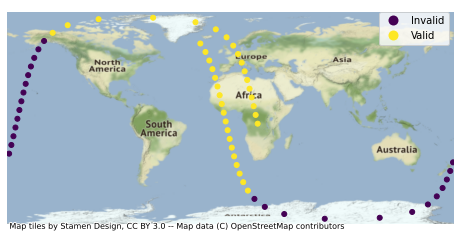

In [4]:
import geoplot as gplt
import contextily as ctx

ax = gplt.pointplot(
    results,
    hue=results.apply(lambda r: "Valid" if r.valid_obs else "Invalid", axis=1),
    legend=True,
)
ctx.add_basemap(ax, crs=results.crs)

The `collect_ground_track` method projects a ground track using knowledge of the instrument. The default setting applies a buffer equivalent to the half swath width to each point in the EPSG:4087 World Equidistant Cylindrical coordinate system. The resulting Polygon geometry is automatically split into a MultiPolygon when crossing the anti-meridian (+/- 180 degrees longitude) and/or the north/south pole (+/- 90 degrees latitude).

In [5]:
from tatc.analysis import collect_ground_track

results = collect_ground_track(noaa20, viirs, times)
display(results)

C:\Users\pgrogan\anaconda3\envs\tatc_env\lib\site-packages\pandas\core\dtypes\cast.py:1983: ShapelyDeprecationWarning: __len__ for multi-part geometries is deprecated and will be removed in Shapely 2.0. Check the length of the `geoms` property instead to get the  number of parts of a multi-part geometry.
  result[:] = values


,time,satellite,instrument,swath_width,valid_obs,geometry
0,2022-07-14 12:00:00+00:00,NOAA 20,VIIRS,2.981788e+06,True,"POLYGON ((35.34602 -4.30943, 35.28153 -5.62217..."
1,2022-07-14 12:02:00+00:00,NOAA 20,VIIRS,2.976785e+06,True,"POLYGON ((33.74595 2.74586, 33.68157 1.43532, ..."
2,2022-07-14 12:04:00+00:00,NOAA 20,VIIRS,2.974387e+06,True,"POLYGON ((32.14456 9.80113, 32.08023 8.49166, ..."
3,2022-07-14 12:06:00+00:00,NOAA 20,VIIRS,2.974522e+06,True,"POLYGON ((30.50717 16.85117, 30.44284 15.54163..."
4,2022-07-14 12:08:00+00:00,NOAA 20,VIIRS,2.976972e+06,True,"POLYGON ((28.79240 23.89045, 28.72801 22.57984..."
...,...,...,...,...,...,...
56,2022-07-14 13:52:00+00:00,NOAA 20,VIIRS,2.982751e+06,True,"POLYGON ((1.07808 32.67577, 1.01357 31.36261, ..."
57,2022-07-14 13:54:00+00:00,NOAA 20,VIIRS,2.988980e+06,True,"POLYGON ((-1.04580 39.66645, -1.11044 38.35055..."
58,2022-07-14 13:56:00+00:00,NOAA 20,VIIRS,2.996045e+06,True,"POLYGON ((-3.53607 46.61973, -3.60087 45.30072..."
59,2022-07-14 13:58:00+00:00,NOAA 20,VIIRS,3.003364e+06,True,"POLYGON ((-6.61802 53.51795, -6.68298 52.19571..."


While fast, the EPSG:4087 coordinate reference frame is not accurate near the poles, as seen in the plot below.

C:\Users\pgrogan\anaconda3\envs\tatc_env\lib\site-packages\geoplot\geoplot.py:982: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  for subgeom in geom:


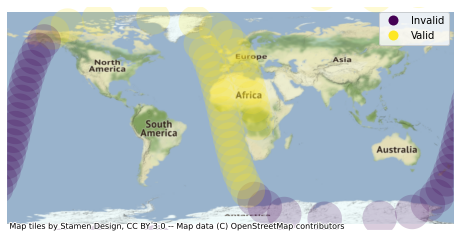

In [6]:
import geoplot as gplt
import contextily as ctx

ax = gplt.choropleth(
    results,
    hue=results.apply(lambda r: "Valid" if r.valid_obs else "Invalid", axis=1),
    edgecolor="none",
    alpha=0.2,
    legend=True,
)
ctx.add_basemap(ax, crs=results.crs)

Alternatively, setting `crs="utm"` uses the Universal Transverse Mercator (UTM) coordinate reference system to more accurately project swath width near the poles. Note that UTM does not cover the regions above 84 degrees or below -80 degrees latitude. These regions instead use the Unified Polar Stereographic (UPS) CRS; however, with poor performance close to the transition point between zones.

C:\Users\pgrogan\anaconda3\envs\tatc_env\lib\site-packages\pandas\core\dtypes\cast.py:1983: ShapelyDeprecationWarning: __len__ for multi-part geometries is deprecated and will be removed in Shapely 2.0. Check the length of the `geoms` property instead to get the  number of parts of a multi-part geometry.
  result[:] = values
C:\Users\pgrogan\anaconda3\envs\tatc_env\lib\site-packages\geoplot\geoplot.py:982: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  for subgeom in geom:


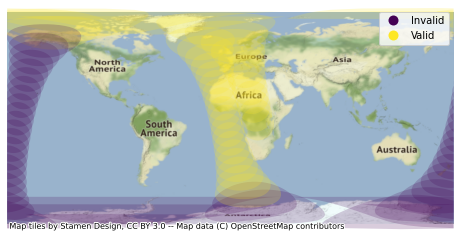

In [7]:
results = collect_ground_track(noaa20, viirs, times, crs="utm")

ax = gplt.choropleth(
    results,
    hue=results.apply(lambda r: "Valid" if r.valid_obs else "Invalid", axis=1),
    edgecolor="none",
    alpha=0.2,
    legend=True,
)
ctx.add_basemap(ax, crs=results.crs)

The results can also be processed using `compute_ground_track` to dissolve geometries.

C:\Users\pgrogan\anaconda3\envs\tatc_env\lib\site-packages\pandas\core\dtypes\cast.py:1983: ShapelyDeprecationWarning: __len__ for multi-part geometries is deprecated and will be removed in Shapely 2.0. Check the length of the `geoms` property instead to get the  number of parts of a multi-part geometry.
  result[:] = values
C:\Users\pgrogan\anaconda3\envs\tatc_env\lib\site-packages\geoplot\geoplot.py:885: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  for subgeom in geom:


Point method (default CRS) completed in 0.29 seconds


C:\Users\pgrogan\anaconda3\envs\tatc_env\lib\site-packages\pandas\core\dtypes\cast.py:1983: ShapelyDeprecationWarning: __len__ for multi-part geometries is deprecated and will be removed in Shapely 2.0. Check the length of the `geoms` property instead to get the  number of parts of a multi-part geometry.
  result[:] = values
C:\Users\pgrogan\anaconda3\envs\tatc_env\lib\site-packages\geoplot\geoplot.py:885: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  for subgeom in geom:


Point method (UTM CRS) completed in 3.73 seconds


C:\Users\pgrogan\anaconda3\envs\tatc_env\lib\site-packages\numpy\lib\shape_base.py:769: ShapelyDeprecationWarning: __len__ for multi-part geometries is deprecated and will be removed in Shapely 2.0. Check the length of the `geoms` property instead to get the  number of parts of a multi-part geometry.
  Ntotal = len(ary)
C:\Users\pgrogan\anaconda3\envs\tatc_env\lib\site-packages\numpy\core\fromnumeric.py:54: ShapelyDeprecationWarning: The array interface is deprecated and will no longer work in Shapely 2.0. Convert the '.coords' to a numpy array instead.
  return _wrapit(obj, method, *args, **kwds)
C:\Users\pgrogan\anaconda3\envs\tatc_env\lib\site-packages\geoplot\geoplot.py:885: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  for subgeom in geom:


Line method (default CRS) completed in 0.21 seconds


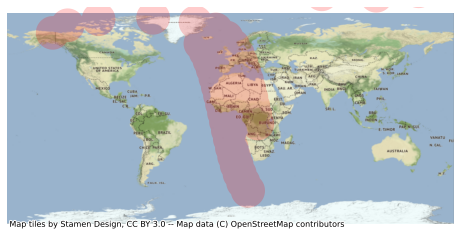

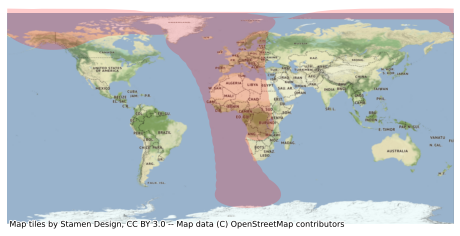

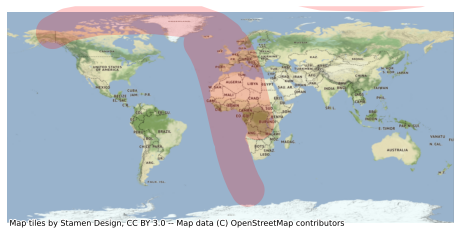

In [8]:
from tatc.analysis import compute_ground_track

import geoplot as gplt
import contextily as ctx
import time

t = time.time()
results = compute_ground_track(noaa20, viirs, times, method="point")
print(f"Point method (default CRS) completed in {time.time() - t:.2f} seconds")
ax = gplt.polyplot(
    results,
    facecolor="r",
    edgecolor="none",
    alpha=0.2,
    zorder=1,
)
ctx.add_basemap(ax, crs=results.crs)

t = time.time()
results = compute_ground_track(noaa20, viirs, times, crs="utm", method="point")
print(f"Point method (UTM CRS) completed in {time.time() - t:.2f} seconds")
ax = gplt.polyplot(
    results,
    facecolor="r",
    edgecolor="none",
    alpha=0.2,
    zorder=1,
)
ctx.add_basemap(ax, crs=results.crs)

t = time.time()
results = compute_ground_track(noaa20, viirs, times, method="line")
print(f"Line method (default CRS) completed in {time.time() - t:.2f} seconds")
ax = gplt.polyplot(
    results,
    facecolor="r",
    edgecolor="none",
    alpha=0.2,
    zorder=1,
)
ctx.add_basemap(ax, crs=results.crs)